In [19]:
# Import necessary libraries
import cv2
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Convolution2D, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import gdown
from deepface.basemodels import VGGFace
from deepface.commons import functions

In [20]:
# Check TensorFlow version for compatibility
tf_version = int(tf.__version__.split(".", maxsplit=1)[0])
if tf_version == 1:
    from keras.models import Model, Sequential
    from keras.layers import Convolution2D, Flatten, Activation
elif tf_version == 2:
    from tensorflow.keras.models import Model, Sequential
    from tensorflow.keras.layers import Convolution2D, Flatten, Activation


In [21]:
race_mapping = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Others"  # Others include Hispanic, Latino, Middle Eastern, etc.
}


In [22]:
# Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (200, 200))
    return img_to_array(img) / 255.0


In [23]:
# Function to parse filename and extract labels
def parse_labels(filename):
    parts = os.path.basename(filename).split("_")
    age = int(parts[0])
    gender = int(parts[1])
    race = int(parts[2])
    return age, gender, race

In [24]:
# Data Generator

def safe_parse_labels(filename):
    try:
        parts = os.path.basename(filename).split("_")
        if len(parts) < 3:  # Check if filename has enough parts
            return None
        age = int(parts[0])
        gender = int(parts[1])
        race = int(parts[2])
        return age, gender, race
    except ValueError:
        return None


In [25]:
def age_data_generator(file_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_input = []
        batch_age_output = []

        for input_path in batch_paths:
            labels = safe_parse_labels(input_path)
            if labels is None:  # Skip files with incorrect format
                continue
            image = preprocess_image(input_path)
            age, _, _ = labels
            batch_input.append(image)
            batch_age_output.append(age)

        if not batch_input:  # Skip batch if empty
            continue

        yield np.array(batch_input, dtype='float32'), np.array(batch_age_output, dtype='float32')

In [26]:
def gender_data_generator(file_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_input = []
        batch_gender_output = []

        for input_path in batch_paths:
            labels = safe_parse_labels(input_path)
            if labels is None:  # Skip files with incorrect format
                continue
            image = preprocess_image(input_path)
            _, gender, _ = labels
            batch_input.append(image)
            batch_gender_output.append(gender)

        if not batch_input:  # Skip batch if empty
            continue

        yield np.array(batch_input, dtype='float32'), np.array(batch_gender_output, dtype='float32')

In [27]:
def race_data_generator(file_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_input = []
        batch_race_output = []

        for input_path in batch_paths:
            labels = safe_parse_labels(input_path)
            if labels is None:  # Skip files with incorrect format
                continue
            image = preprocess_image(input_path)
            _, _, race = labels
            batch_input.append(image)
            batch_race_output.append(race)

        if not batch_input:  # Skip batch if empty
            continue

        # Convert race to categorical format
        batch_race_output_categorical = to_categorical(batch_race_output, num_classes=len(race_mapping))

        yield np.array(batch_input, dtype='float32'), batch_race_output_categorical

        # Convert lists to numpy arrays
        X = np.array(batch_input, dtype='float32')
        Y_age = np.array(batch_age_output, dtype='float32')
        Y_gender = np.array(batch_gender_output, dtype='float32')
        Y_ethnicity = to_categorical(batch_ethnicity_output, num_classes=5)

        yield X, {'age_output': Y_age, 'gender_output': Y_gender, 'ethnicity_output': Y_ethnicity}
        


In [28]:
# Path to your images directory
images_directory = 'E:/capJC/paper/part1'  # Update with your path
img_paths = glob(os.path.join(images_directory, "*.jpg"))

# Splitting dataset into training and testing
train_paths, test_paths = train_test_split(img_paths, test_size=0.2, random_state=42)

# Define batch size
batch_size = 32  # Adjust this based on your memory constraints

# Training data generator
# Training data generators
train_age_generator = age_data_generator(train_paths, batch_size)
train_gender_generator = gender_data_generator(train_paths, batch_size)

In [29]:
# Define the age_model
age_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, name='age_output')
])
age_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [30]:
# Define the gender_model
gender_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid', name='gender_output')
])
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Load pre-built model for ethnicity prediction
def load_ethnicity_model(url="https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5"):
    model = VGGFace.baseModel()
    classes = 6
    base_model_output = Sequential()
    base_model_output = Convolution2D(classes, (1, 1), name="predictions")(model.layers[-4].output)
    base_model_output = Flatten()(base_model_output)
    base_model_output = Activation("softmax")(base_model_output)
    race_model = Model(inputs=model.input, outputs=base_model_output)

    # Load weights
    home = functions.get_deepface_home()
    output = home + "/.deepface/weights/race_model_single_batch.h5"
    if not os.path.isfile(output):
        print("race_model_single_batch.h5 will be downloaded...")
        gdown.download(url, output, quiet=False)
    race_model.load_weights(output)
    return race_model

ethnicity_model = load_ethnicity_model()

In [32]:
def age_data_generator(file_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_input = []
        batch_age_output = []

        for input_path in batch_paths:
            image = preprocess_image(input_path)
            age, _, _ = parse_labels(input_path)

            batch_input.append(image)
            batch_age_output.append(age)

        X = np.array(batch_input, dtype='float32')
        Y_age = np.array(batch_age_output, dtype='float32')

        yield X, Y_age

In [33]:
def gender_data_generator(file_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_input = []
        batch_gender_output = []

        for input_path in batch_paths:
            image = preprocess_image(input_path)
            _, gender, _ = parse_labels(input_path)

            batch_input.append(image)
            batch_gender_output.append(gender)

        X = np.array(batch_input, dtype='float32')
        Y_gender = np.array(batch_gender_output, dtype='float32')

        yield X, Y_gender

In [34]:
# Training data generators
train_age_generator = age_data_generator(train_paths, batch_size)
train_gender_generator = gender_data_generator(train_paths, batch_size)

In [17]:
# Calculate steps_per_epoch
steps_per_epoch = len(train_paths) // batch_size

# Train the age model
history_age = age_model.fit(
    train_age_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=10
)

# Train the gender model
history_gender = gender_model.fit(
    train_gender_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=10
)


Epoch 1/10


 12/602 [..............................] - ETA: 7:42 - loss: 2163.9846 - mae: 37.3752

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
ValueError: invalid literal for int() with base 10: ''
Traceback (most recent call last):

  File "C:\Users\hvbvm\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\hvbvm\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\hvbvm\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\hvbvm\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\hvbvm\AppData\Local\Temp\ipykernel_10664\1484312716.py", line 9, in age_data_generator
    age, _, _ = parse_labels(input_path)
                ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\hvbvm\AppData\Local\Temp\ipykernel_10664\761029784.py", line 5, in parse_labels
    gender = int(parts[1])
             ^^^^^^^^^^^^^

ValueError: invalid literal for int() with base 10: ''


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1730]

In [ ]:
# 4. Evaluate the Models and Visualize Performance Metrics
# Evaluate Age Model

#Age-test generator:

def age_test_data_generator(file_paths, batch_size):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_input = []
            batch_age_output = []

            for input_path in batch_paths:
                labels = safe_parse_labels(input_path)
                if labels is None:  # Skip files with incorrect format
                    continue
                image = preprocess_image(input_path)
                age, _, _ = labels
                batch_input.append(image)
                batch_age_output.append(age)

            yield np.array(batch_input, dtype='float32'), np.array(batch_age_output, dtype='float32')


In [ ]:
#Evaluating the age_model:

# Create test data generator for age
test_age_generator = age_test_data_generator(test_paths, batch_size)

# Calculate the number of steps needed for the test generator
num_test_steps = len(test_paths) // batch_size + (len(test_paths) % batch_size != 0)

# Evaluate Age Model
age_loss, age_mae = age_model.evaluate(test_age_generator, steps=num_test_steps)
print("Age Model - Loss:", age_loss, "MAE:", age_mae)


151/151 [==============================] - 39s 258ms/step - loss: 378.1849 - mae: 14.8367
Age Model - Loss: 378.18487548828125 MAE: 14.836714744567871


In [ ]:
# Evaluate Gender_Model:


def gender_test_data_generator(file_paths, batch_size):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_input = []
            batch_gender_output = []

            for input_path in batch_paths:
                labels = safe_parse_labels(input_path)
                if labels is None:  # Skip files with incorrect format
                    continue
                image = preprocess_image(input_path)
                _, gender, _ = labels
                batch_input.append(image)
                batch_gender_output.append(gender)

            yield np.array(batch_input, dtype='float32'), np.array(batch_gender_output, dtype='float32')


In [ ]:
# Create test data generator for gender
test_gender_generator = gender_test_data_generator(test_paths, batch_size)

# Calculate the number of steps needed for the test generator
num_test_steps = len(test_paths) // batch_size + (len(test_paths) % batch_size != 0)

# Evaluate Gender Model
gender_loss, gender_acc = gender_model.evaluate(test_gender_generator, steps=num_test_steps)
print("Gender Model - Loss:", gender_loss, "Accuracy:", gender_acc)


151/151 [==============================] - 33s 216ms/step - loss: 1.4925 - accuracy: 0.6804
Gender Model - Loss: 1.4925291538238525 Accuracy: 0.6804230809211731


In [ ]:
# data generator for ethncity_detect:
def ethnicity_test_data_generator(file_paths, batch_size):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_input = []

            for input_path in batch_paths:
                image = preprocess_image(input_path)
                batch_input.append(image)

            yield np.array(batch_input, dtype='float32')

# Create test data generator for ethnicity
test_ethnicity_generator = ethnicity_test_data_generator(test_paths, batch_size)


In [ ]:
#Ethnicity- Modified Image Preprocessing Function

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to (224, 224)
    return img_to_array(img) / 255.0


In [ ]:
def ethnicity_test_data_generator(file_paths, batch_size):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_input = []

            for input_path in batch_paths:
                image = preprocess_image(input_path)
                batch_input.append(image)

            yield np.array(batch_input, dtype='float32')


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

batch_size=32

def ethnicity_data_generator(file_paths, batch_size):
    num_files = len(file_paths)
    for i in range(0, num_files, batch_size):
        batch_paths = file_paths[i:i+batch_size]
        batch_images = []
        batch_labels = []

        for file_path in batch_paths:
            img = preprocess_image(file_path)  # Ensure this is defined and resizes images to (200, 200, 3)
            batch_images.append(img)

            # Extract labels
            parts = file_path.split('_')
            if len(parts) >= 4:
                race = int(parts[2])
                batch_labels.append(race)
            else:
                # Handle error: skip this file or use a default value
                continue

        # Yield batch
        yield np.array(batch_images), to_categorical(batch_labels, num_classes=len(race_mapping))

def calculate_accuracy(file_paths, generator_func, model, batch_size):
    all_labels = []
    all_predictions = []
    num_steps = len(file_paths) // batch_size

    # Generate predictions for full batches
    generator = generator_func(file_paths, batch_size)
    for _ in range(num_steps):
        images, labels = next(generator)
        predictions_batch = model.predict(images)
        predicted_classes = np.argmax(predictions_batch, axis=1)
        true_classes = np.argmax(labels, axis=1)
        all_labels.extend(true_classes)
        all_predictions.extend(predicted_classes)

    # Handle the last partial batch, if there is one
    last_batch_size = len(file_paths) % batch_size
    if last_batch_size > 0:
        # Process the remainder of the files
        images, labels = next(generator)
        predictions_batch = model.predict(images[:last_batch_size])
        predicted_classes = np.argmax(predictions_batch, axis=1)
        true_classes = np.argmax(labels[:last_batch_size], axis=1)
        all_labels.extend(true_classes)
        all_predictions.extend(predicted_classes)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Example usage:
# Assuming 'ethnicity_model' is your trained Keras model
# Assuming 'test_paths' is a list of file paths for the test set
# Assuming 'batch_size' is defined
accuracy = calculate_accuracy(test_paths, ethnicity_data_generator, ethnicity_model, batch_size)
print(f"Ethnicity prediction accuracy: {accuracy * 100:.2f}%")





1/1 [==============================] - 3s 3s/step


KeyboardInterrupt: 

In [ ]:
# Ethnicity Prediction and Evaluation

def evaluate_model(test_generator_func, model, num_steps, batch_size):
    test_generator = test_generator_func(num_test_steps, batch_size)
    predictions = []
    for _ in range(num_steps):
        X_batch, _ = next(test_generator)
        predictions_batch = model.predict(X_batch)
        predictions.extend(predictions_batch)

    return np.array(predictions)

# Calculate the number of steps needed for the test generator
num_test_steps = len(test_paths) // batch_size + (len(test_paths) % batch_size != 0)

# Create the test data generator for ethnicity
test_ethnicity_generator = ethnicity_test_data_generator(test_paths, batch_size)

# Predict ethnicity
ethnicity_pred = predict_ethnicity(test_ethnicity_generator, num_test_steps)

# Obtain actual ethnicity labels for the test set
ethnicity_test_labels = [safe_parse_labels(path)[2] for path in test_paths if safe_parse_labels(path) is not None]
ethnicity_test_labels_categorical = to_categorical([race_mapping[race] for race in ethnicity_test_labels], num_classes=len(race_mapping))

# Calculate accuracy
correct_predictions = np.argmax(ethnicity_test_labels_categorical, axis=1) == ethnicity_pred
ethnicity_accuracy = np.mean(correct_predictions)
print("Ethnicity Prediction Accuracy: {:.2f}%".format(ethnicity_accuracy * 100))




1/1 [==============================] - 2s 2s/step


KeyboardInterrupt: 

In [ ]:
# Assuming gender_model is already defined
history_gender = gender_model.fit(
    X_train, gender_train,
    validation_split=0.1,  # using 10% of data for validation
    epochs=10,  # Number of epochs
    batch_size=32  # Batch size, adjust based on your dataset
)

In [ ]:
# Assuming age_model is already defined
history_age = age_model.fit(
    X_train, age_train,
    validation_split=0.1,  # using 10% of data for validation
    epochs=10,  # Number of epochs
    batch_size=32  # Batch size, adjust based on your dataset
)


NameError: name 'age_model' is not defined

KeyError: 'val_loss'

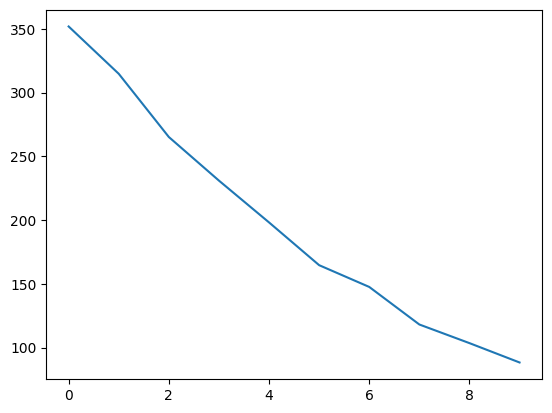

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss
def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot training and validation accuracy
def plot_accuracy(history, title, is_binary=False):
    plt.figure()
    acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
    
    plt.plot(history.history[acc_key], label='Training Accuracy')
    plt.plot(history.history[val_acc_key], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy' if is_binary else 'MAE')
    plt.legend()
    plt.show()

# Plotting performance metrics for Age Model
plot_loss(history_age, 'Age Prediction Model - Loss')
plot_accuracy(history_age, 'Age Prediction Model - MAE', is_binary=False)

# Plotting performance metrics for Gender Model
plot_loss(history_gender, 'Gender Prediction Model - Loss')
plot_accuracy(history_gender, 'Gender Prediction Model - Accuracy', is_binary=True)


In [ ]:
# Ethnicity Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(ethnicity_test_data_generator, axis=1), ethnicity_pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=race_mapping, yticklabels=race_mapping)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ethnicity Prediction Confusion Matrix')
plt.show()

AxisError: axis 2 is out of bounds for array of dimension 1